In [18]:
import os
import json
from pathlib import Path
import sys
BASE_DIR = str(Path().resolve().parents[0])
if BASE_DIR not in sys.path:
    sys.path.insert(0, BASE_DIR)
import src.news_nlp.config.paths as paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy.linalg as LA
import joblib
import random

from dotenv import load_dotenv
from llms_inferer import Llms_inferer

In [19]:
# Global config
RANDOM_SEED = 31415

# Parameters
N_COMPONENTS = 100
K_VALUES = [10, 15, 20, 30, 40, 50]
N_TOP_TERMS = 10

# Load data

In [20]:
df_train = pd.read_parquet(paths.DF_TRAIN_CLEAN)
df_train

,news_id,title,content,text
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen..."
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...
...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi..."


In [21]:
# Extract column "text" as a list of strings, to be used for TF-IDF vectorization
texts = df_train["text"].astype(str).tolist()
len(texts)

89795

# Vectorization with TF-IDF

In [22]:
"""
TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents (corpus). It is widely used in information retrieval and text mining to evaluate how relevant a word is to a specific document while considering its overall frequency in the entire corpus. The TF-IDF value increases proportionally with the number of times a word appears in a document but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words are generally more common than others.
A word is considered important to a document if it appears frequently in that document but not in many other documents in the corpus.
The TF-IDF score for a word in a document is calculated using two main components:
1. Term Frequency (TF): This measures how frequently a word appears in a document. It is calculated as the number of times a word appears in the document divided by the total number of words in that document.
2. Inverse Document Frequency (IDF): This measures how important a word is across the entire corpus. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the word. Words that appear in many documents will have a lower IDF score, indicating they are less informative.
The TF-IDF score is then computed by multiplying the TF and IDF values:
TF-IDF(word, document) = TF(word, document) * IDF(word, corpus)
By using TF-IDF, we can identify words that are particularly significant to a specific document while downplaying common words that may not carry much meaning. This makes TF-IDF a powerful tool for tasks such as document classification, clustering, and information retrieval.
"""

'\nTF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents (corpus). It is widely used in information retrieval and text mining to evaluate how relevant a word is to a specific document while considering its overall frequency in the entire corpus. The TF-IDF value increases proportionally with the number of times a word appears in a document but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words are generally more common than others.\nA word is considered important to a document if it appears frequently in that document but not in many other documents in the corpus.\nThe TF-IDF score for a word in a document is calculated using two main components:\n1. Term Frequency (TF): This measures how frequently a word appears in a document. It is calculated as the number of times a word appears in the document divided by the total nu

TF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is a word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.

In [ ]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
    max_features=30000,      # limits to top 30k features
    ngram_range=(1, 2),      # unigrams and bi-grams
    stop_words="english",
    min_df=5,                # at least in 5 documents
    max_df=0.7               # discards very frequent terms
)

: 

In [ ]:
# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

In [ ]:
# Get feature names (words)
tfidf.get_feature_names_out()

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

# Dimension reduction with Truncated SVD

In [ ]:
"""
TF-IDF Vectorization gives a massive matrix (90k x 30k) where each row is a news article and each column is a word. But there are probably less topics/ideas than words. E.g., government, parliament, law, minister, are all related to politics.
So we can reduce the dimensionality of this matrix using TruncatedSVD (Singular Value Decomposition), which keeps the given number of components dimensions (100) that represent more abstract ideas (latent topics). This is call LSA (Latent Semantic Analysis).
And what we are going to do is reduce the 30k words to 100 latent topics. And then, we will cluster this reduced 100-dimensional space instead of the original 30k-dimensional space. Which will make clustering faster and probably better.
"""

'\nTF-IDF Vectorization gives a massive matrix (90k x 30k) where each row is a news article and each column is a word. But there are probably less topics/ideas than words. E.g., government, parliament, law, minister, are all related to politics.\nSo we can reduce the dimensionality of this matrix using TruncatedSVD (Singular Value Decomposition), which keeps the given number of components dimensions (100) that represent more abstract ideas (latent topics). This is call LSA (Latent Semantic Analysis).\nAnd what we are going to do is reduce the 30k words to 100 latent topics. And then, we will cluster this reduced 100-dimensional space instead of the original 30k-dimensional space. Which will make clustering faster and probably better.\n'

Reduce from 30K dimensions to N_COMPONENTS latent components (LSA). This will reduce noise and make clustering faster and more stable.

In [ ]:
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_SEED)
svd

,n_components,100
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [ ]:
# Noramailzer helps to make distances for K-means more stable
normalizer = Normalizer(copy=False)
normalizer

,norm,'l2'
,copy,False


In [ ]:
# Create a pipeline that first applies SVD and then normalizes the result
svd_pipeline = make_pipeline(svd, normalizer)
svd_pipeline

,steps,"[('truncatedsvd', ...), ('normalizer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,100
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [ ]:
# Fit and transform the TF-IDF matrix to obtain the reduced representation
X_reduced = svd_pipeline.fit_transform(X_tfidf)
X_reduced.shape

(89795, 100)

In [ ]:
# explained_var = svd.explained_variance_ratio_.sum()
# explained_var

# Clustering with K-Means

In [ ]:
"""
Now we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.
"""

'\nNow we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.\n'

In [ ]:
def evaluate_k(k_values, X):
    """
    Trains K-means for each k in k_values and computes the silhouette score.
    Args:
        k_values (list): List of k values to evaluate.
        X (array-like): Data to cluster.
    Returns:
        results (list): List of dicts with k and silhouette score.
    """
    results = []
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init="auto")
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        results.append({"k": k, "silhouette": sil})
        # print(f"k={k}, silhouette={sil:.4f}")
    return results

In [ ]:
results = evaluate_k(K_VALUES, X_reduced)
df_results = pd.DataFrame(results)
df_results

KeyboardInterrupt: 

Text(0, 0.5, 'Silhoutte score')

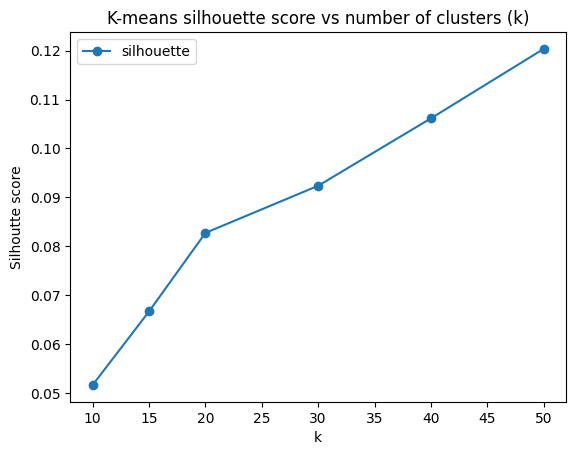

In [ ]:
df_results.plot(
    x="k",
    y="silhouette",
    marker="o",
    title="K-means silhouette score vs number of clusters (k)"
)
plt.xlabel("k")
plt.ylabel("Silhoutte score")

In [ ]:
selected_k = 30
# selected_k = int(df_results.loc[df_results["silhouette"].idxmax(), "k"])

In [ ]:
# Train final K-means model with the selected number of clusters
kmeans = KMeans(n_clusters=selected_k, random_state=RANDOM_SEED, n_init="auto")
cluster_labels = kmeans.fit_predict(X_reduced)

df_train["topic_id"] = cluster_labels
df_train[["news_id", "topic_id"]]

,news_id,topic_id
0,0,25
1,1,15
2,2,25
3,3,18
4,4,22
...,...,...
89923,89923,6
89924,89924,13
89925,89925,15
89926,89926,16


# Inspect topics

In [ ]:
# Get the vocabulary (feature names) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

In [ ]:
def show_cluster_examples(df, topic_id, n=5):
    """
    Show n example titles from the given cluster_id.
    """
    subset = df[df["topic_id"] == topic_id].sample(n, random_state=RANDOM_SEED)
    for i, row in subset.iterrows():
        print(f"- {row['title']}")

In [ ]:
def top_terms_for_cluster(X_tfidf, labels, topic_id, n_terms=15):
    """
    Get the top n_terms with highest average TF-IDF score in the given cluster_id.
    Args:
        X_tfidf (sparse matrix): TF-IDF matrix.
        labels (array-like): Cluster labels for each document.
        topic_id (int): Cluster ID to analyze.
        n_terms (int): Number of top terms to return.
    Returns:
        list: Top n_terms feature names for the cluster.
    """
    idx = np.where(labels == topic_id)[0]
    X_cluster = X_tfidf[idx]
    # suma de tfidf en el cluster
    tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = tfidf_mean.argsort()[::-1][:n_terms]
    return [feature_names[i] for i in top_idx]

In [ ]:
# Display top terms and example titles for some random clusters
random.seed(RANDOM_SEED)
for c in random.sample(range(selected_k), 5):
    print(f"\n=== CLUSTER {c} ===")
    print(top_terms_for_cluster(X_tfidf, cluster_labels, c))
    show_cluster_examples(df_train, c, n=3)


=== CLUSTER 18 ===
['election', 'senate', 'democrats', 'republican', 'republicans', 'voting', 'vote', 'state', 'house', 'party', 'said', 'voters', 'gop', 'democratic', 'trump']
- California Democrats sharpen messaging against Newsom recall
- Wide-Ranging Lawsuit Against Florida GOP Under Consideration By Star Lawyer
- At least 4 candidates challenging Gavin Newsom have expressed 'some level of support' for QAnon: report

=== CLUSTER 25 ===
['cbs', 'cbs news', 'news', 'correspondent', 'joins', 'cbsn', 'evening news', 'cbs evening', 'cbs morning', 'morning', 'discuss', 'joins cbsn', 'evening', 'headlines', 'joins cbs']
- Friends of Princess Diana discuss her legacy in CBS special
- Two American trainers killed in shooting in Jordan
- FDA approves female libido pill

=== CLUSTER 9 ===
['women', 'bbc', 'said', 'rittenhouse', 'says', 'black', 'prince', 'actor', 'chicago', 'white', 'korea', 'people', 'city', 'president', 'north']
- 7/9: Haley, McCain, Cruz
- California recall election down 

# Building of topics metadata

In [ ]:
# Build a df with a register per topic/cluster
df_topics_meta = (
    df_train
    .groupby("topic_id")
    .agg(size=("news_id", "count"))
    .reset_index()
)

df_topics_meta["top_terms"] = df_topics_meta["topic_id"].apply(
    lambda c: top_terms_for_cluster(X_tfidf, cluster_labels, c, n_terms=N_TOP_TERMS)
)

df_topics_meta

,topic_id,size,top_terms
0,0,3470,"[covid, covid 19, 19, pandemic, said, people, ..."
1,1,2771,"[school, students, university, schools, campus..."
2,2,3565,"[police, officers, officer, said, shooting, ma..."
3,3,2347,"[health, dr, patients, care, cancer, medical, ..."
4,4,2000,"[league, england, villa, club, premier league,..."
5,5,4297,"[court, said, judge, case, trial, prison, murd..."
6,6,6427,"[people, like, said, just, know, time, think, ..."
7,7,2962,"[man, police, year old, old, police said, said..."
8,8,4282,"[israel, iran, military, israeli, myanmar, rus..."
9,9,8407,"[women, bbc, said, rittenhouse, says, black, p..."


# Automatic naming of clusters

In [ ]:
# Load environment variables from .env file
load_dotenv(paths.ENV_FILE)

True

In [ ]:
# Insantiate the inferer using ChatGPT5 and the prompt.yaml file
inferer = Llms_inferer(
    model="gpt-5",
    prompts_path=paths.PROMPTS_FILE,
    api_key=os.getenv("OPENAI_API_KEY", None), run_local=False)

In [ ]:
# Get the system prompt for the topics_namer module
system_prompt = inferer.get_prompt(module="topics_namer")
system_prompt

'In the next user prompt, you will receive a json whose keys are cluster ids and its values are two dictionaries: "terms" and "titles".\n"terms" contains a list the most relevant words for that cluster, and "titles" contains a list of several news article titles related to that cluster, to help you understand its context.\nYour task is to generate a concise and descriptive label for each cluster based on the words and titles provided.\nThe labels should accurately reflect the common theme or topic represented by the words in each cluster.\nThe labels should be brief, ideally consisting of one to three words, and should avoid using overly generic terms. Focus on capturing the essence of the cluster in a way that is informative and specific.\nAlways answer in English and use title case for the labels (e.g., "Climate Change", "Artificial Intelligence").\nOutput the results as a JSON object where each key is the original cluster id and each value is the generated label for that cluster.\nD

In [ ]:
# Create the user prompt as a JSON object
user_prompt = {int(row["topic_id"]): row["top_terms"] for _, row in df_topics_meta.iterrows()}
user_prompt = json.dumps(user_prompt)
user_prompt

'{"0": ["covid", "covid 19", "19", "pandemic", "said", "people", "cases", "vaccine", "health", "vaccines"], "1": ["school", "students", "university", "schools", "campus", "student", "said", "education", "teachers", "campus reform"], "2": ["police", "officers", "officer", "said", "shooting", "man", "police said", "police officer", "city", "shot"], "3": ["health", "dr", "patients", "care", "cancer", "medical", "hospital", "study", "said", "people"], "4": ["league", "england", "villa", "club", "premier league", "players", "premier", "football", "game", "cup"], "5": ["court", "said", "judge", "case", "trial", "prison", "murder", "attorney", "prosecutors", "supreme"], "6": ["people", "like", "said", "just", "know", "time", "think", "life", "want", "going"], "7": ["man", "police", "year old", "old", "police said", "said", "year", "shot", "shooting", "chicago"], "8": ["israel", "iran", "military", "israeli", "myanmar", "russia", "war", "gaza", "syria", "said"], "9": ["women", "bbc", "said", "

In [ ]:
# Call the inferer to get topic names
response = inferer.infer(
    system_prompt=system_prompt,
    prompt=user_prompt
)
response

'{"0": "COVID-19 Pandemic", "1": "Higher Education", "2": "Police Shootings", "3": "Medical Care", "4": "English Premier League", "5": "Legal Proceedings", "6": "Opinion Pieces", "7": "Chicago Shootings", "8": "Middle East Conflicts", "9": "Culture & Society", "10": "Biden Administration", "11": "COVID-19 Variants", "12": "U.S.-Mexico Border", "13": "Climate Change", "14": "Trump Politics", "15": "Severe Weather", "16": "Inflation & Markets", "17": "Social Media Sharing", "18": "U.S. Elections", "19": "Chicago Sports", "20": "Gun Control", "21": "COVID-19 Vaccines", "22": "Social Media Platforms", "23": "Brexit Politics", "24": "Capitol Riot", "25": "CBS News", "26": "China Politics", "27": "Andrew Cuomo", "28": "Tokyo Olympics", "29": "Afghanistan Withdrawal"}'

In [ ]:
# Parse the response JSON
response_json = json.loads(response)
response_json

{'0': 'COVID-19 Pandemic',
 '1': 'Higher Education',
 '2': 'Police Shootings',
 '3': 'Medical Care',
 '4': 'English Premier League',
 '5': 'Legal Proceedings',
 '6': 'Opinion Pieces',
 '7': 'Chicago Shootings',
 '8': 'Middle East Conflicts',
 '9': 'Culture & Society',
 '10': 'Biden Administration',
 '11': 'COVID-19 Variants',
 '12': 'U.S.-Mexico Border',
 '13': 'Climate Change',
 '14': 'Trump Politics',
 '15': 'Severe Weather',
 '16': 'Inflation & Markets',
 '17': 'Social Media Sharing',
 '18': 'U.S. Elections',
 '19': 'Chicago Sports',
 '20': 'Gun Control',
 '21': 'COVID-19 Vaccines',
 '22': 'Social Media Platforms',
 '23': 'Brexit Politics',
 '24': 'Capitol Riot',
 '25': 'CBS News',
 '26': 'China Politics',
 '27': 'Andrew Cuomo',
 '28': 'Tokyo Olympics',
 '29': 'Afghanistan Withdrawal'}

In [ ]:
# And create a DataFrame with topic_id and topic_name
df_topics_labels = pd.DataFrame(
    [{"topic_id": int(k), "topic_name": v} for k, v in response_json.items()]
)
df_topics_labels

,topic_id,topic_name
0,0,COVID-19 Pandemic
1,1,Higher Education
2,2,Police Shootings
3,3,Medical Care
4,4,English Premier League
5,5,Legal Proceedings
6,6,Opinion Pieces
7,7,Chicago Shootings
8,8,Middle East Conflicts
9,9,Culture & Society


In [ ]:
# Merge the topic names back into the topics metadata DataFrame
df_topics_meta = df_topics_meta.merge(
    df_topics_labels, on="topic_id", how="left"
)
df_topics_meta

,topic_id,size,top_terms,topic_name
0,0,3470,"[covid, covid 19, 19, pandemic, said, people, ...",COVID-19 Pandemic
1,1,2771,"[school, students, university, schools, campus...",Higher Education
2,2,3565,"[police, officers, officer, said, shooting, ma...",Police Shootings
3,3,2347,"[health, dr, patients, care, cancer, medical, ...",Medical Care
4,4,2000,"[league, england, villa, club, premier league,...",English Premier League
5,5,4297,"[court, said, judge, case, trial, prison, murd...",Legal Proceedings
6,6,6427,"[people, like, said, just, know, time, think, ...",Opinion Pieces
7,7,2962,"[man, police, year old, old, police said, said...",Chicago Shootings
8,8,4282,"[israel, iran, military, israeli, myanmar, rus...",Middle East Conflicts
9,9,8407,"[women, bbc, said, rittenhouse, says, black, p...",Culture & Society


In [ ]:
df_train = df_train.merge(
    df_topics_labels, on="topic_id", how="left"
)
df_train

,news_id,title,content,text,topic_id,topic_name
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",25,CBS News
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,15,Severe Weather
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,25,CBS News
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,18,U.S. Elections
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,22,Social Media Platforms
...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,6,Opinion Pieces
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,13,Climate Change
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,15,Severe Weather
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",16,Inflation & Markets


# Add distance to centroid metric

In [ ]:
# Get centroids
centroids = kmeans.cluster_centers_
centroids.shape

(30, 100)

In [ ]:
# Calculate distances to centroids
distances = LA.norm(X_reduced - centroids[cluster_labels], axis=1)
distances.shape

(89928,)

In [ ]:
# Add distance to centroid metric to df_train
df_train["distance_to_centroid"] = distances
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",25,CBS News,0.781011
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,15,Severe Weather,0.639121
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,25,CBS News,0.762167
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,18,U.S. Elections,0.732615
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,22,Social Media Platforms,0.801463
...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,6,Opinion Pieces,0.700948
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,13,Climate Change,0.689949
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,15,Severe Weather,0.845088
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",16,Inflation & Markets,0.864325


# Export DataFrames

In [ ]:
# Enriched df_train
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",25,CBS News,0.781011
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,15,Severe Weather,0.639121
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,25,CBS News,0.762167
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,18,U.S. Elections,0.732615
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,22,Social Media Platforms,0.801463
...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,6,Opinion Pieces,0.700948
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,13,Climate Change,0.689949
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,15,Severe Weather,0.845088
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",16,Inflation & Markets,0.864325


In [ ]:
# Create a DataFrame with the assignments per news article
assignments_cols = ["news_id", "topic_id", "topic_name", "distance_to_centroid"]
df_assignments = df_train[assignments_cols].copy()
df_assignments

,news_id,topic_id,topic_name,distance_to_centroid
0,0,25,CBS News,0.781011
1,1,15,Severe Weather,0.639121
2,2,25,CBS News,0.762167
3,3,18,U.S. Elections,0.732615
4,4,22,Social Media Platforms,0.801463
...,...,...,...,...
89923,89923,6,Opinion Pieces,0.700948
89924,89924,13,Climate Change,0.689949
89925,89925,15,Severe Weather,0.845088
89926,89926,16,Inflation & Markets,0.864325


In [ ]:
# Metadata about topics
df_topics_meta

,topic_id,size,top_terms,topic_name
0,0,3470,"[covid, covid 19, 19, pandemic, said, people, ...",COVID-19 Pandemic
1,1,2771,"[school, students, university, schools, campus...",Higher Education
2,2,3565,"[police, officers, officer, said, shooting, ma...",Police Shootings
3,3,2347,"[health, dr, patients, care, cancer, medical, ...",Medical Care
4,4,2000,"[league, england, villa, club, premier league,...",English Premier League
5,5,4297,"[court, said, judge, case, trial, prison, murd...",Legal Proceedings
6,6,6427,"[people, like, said, just, know, time, think, ...",Opinion Pieces
7,7,2962,"[man, police, year old, old, police said, said...",Chicago Shootings
8,8,4282,"[israel, iran, military, israeli, myanmar, rus...",Middle East Conflicts
9,9,8407,"[women, bbc, said, rittenhouse, says, black, p...",Culture & Society


In [ ]:
# Export DataFrames
df_train.to_parquet(paths.DF_TRAIN_CLUSTERED, index=False)
df_assignments.to_parquet(paths.DF_ASSIGNMENTS, index=False)
df_topics_meta.to_parquet(paths.DF_TOPICS_META, index=False)

# Export models / artifacts

In [ ]:
# Create models directory if it doesn't exist
paths.DIR_MODELS_TOPICS.mkdir(parents=True, exist_ok=True)
# Save the models
joblib.dump(tfidf, paths.TFIDF_VECTORIZER)
joblib.dump(svd_pipeline, paths.SVD_MODEL)
joblib.dump(kmeans, paths.KMEANS_MODEL)

['/home/ubuntu/news_classifier/models/kmeans_model.joblib']